# Writing your time series package 

In [132]:
import numpy as np
import pandas as pd
import scipy.special
from scipy.special import gamma
from scipy.optimize import minimize, Bounds, LinearConstraint
from scipy.stats import norm
from math import pi
from copy import copy
from time import time

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [25]:
# Step 1: Define a result object to store the results of the estimates

class resultObject:
    
    def __init__(self, parameters, loglike=None, jac=None, hess=None):
        
        self.parameters = parameters
        self.loglike = loglike
        self.jac = jac
        self.hess = hess
        self.resid = None
        self.volatility = None
        self.full_noise = None
        
    def get_parameters(self):
        
        return self.parameters
    
    def get_jac(self):
        
        return self.jac
    
    def get_loglike(self):
        
        return self.loglikehood
    
    def get_hessian(self):
        
        return self.hess
    
    def get_residuals(self):
        
        return self.resid
    
    def get_covariance_matrix(self, robust=0):
        
        if robust==0:
            
            return -np.linalg.inv(self.hess)
        else:
            
            x1 = np.matrix(self.jac)
            X = x1.T@x1
            Z = np.matrix(np.linalg.inv(self.hess))
            
            return np.array(Z@X@Z)
    
    def set_residuals(self, residuals):
        
        self.resid = residuals
    
    def set_volatility(self, volatility):
        
        self.volatility = volatility
        
    def set_full_noise(self, full_noise):
        
        self.full_noise = full_noise
    
    def get_number_of_params(self):
        
        return len(self.parameters)
    


In [30]:
class ARGARCH:
    
    def __init__(self, p, q, lags, density='normal'):
        
        self.p = p # lags for the noise in the volatility process
        self.q = q # lags for the lags of the vol in the volatility process
        self.lags = lags # lags for the autoregressive part in the mean process
        self.density = density
        
    def simulate(self, y0, sigma_square0, n_steps, mu=0, betas=0, omega=0, alphas=0, phis=0, df=4, N=1):
        
        # mu = intercept of the time series yt
        # omega = intercept of the volatility process
        # betas = coefficients for the autoregressive part in the mean process
        # alphas = coefficients for the square noise in the vol process
        # phis = coefficients for the lagged volatilities in the vol process
        # df = degrees of freedom for the Student-t distribution
        
        m = max([self.lags, self.p, self.q])
        
        yt = np.empty((n_steps, N))
        yt[0:m] = y0
        
        sigma_square = np.empty((n_steps, N))
        sigma_square[0:m] = sigma_square0
        
        eps = np.empty((n_steps, N))
        if self.density=='normal':
            eps[0:m] = np.random.normal(0, 1, (m,N))
        elif self.density=='tstudent':
            eps[0:m] = np.random.standard_t(df, (m,N))
        
        for i in range(m, n_steps):
            
            if self.density=='normal':
                
                eps[i] = np.random.normal(0, 1, (1,N))
            
            elif self.density=='tstudent':
                
                eps[i] = np.random.standard_t(df, (1,N))
            
            sigma_square[i] = omega + np.sum(alphas*eps[i-self.p:i]**2, axis=0) + np.sum(phis*sigma_square[i-self.q:i], axis=0);
                        
            yt[i,:] = mu + np.sum(betas*yt[i-self.lags:i],axis=0)  + np.sqrt(sigma_square[i]) * eps[i]
            
        return yt, sigma_square
    
    def get_vol(self, yt, mu=0, betas=0, omega=0, alphas=0, phis=0):
        # getting the volatility from the observed time series 
        
        # mu = intercept of the time series yt
        # omega = intercept of the volatility process
        # betas = coefficients for the autoregressive part in the mean process
        # alphas = coefficients for the square noise in the vol process
        # phis = coefficients for the lagged volatilities in the vol process
        # df = degrees of freedom for the Student-t distribution
        # yt = observed time series
        
        m = max([self.lags, self.p, self.q])
        
        sigma_square = np.empty(len(yt))
        sigma_square[0:m] = np.var(yt)
        
        eps = np.empty(len(yt))
        eps[0:m] = (yt[0:m]-np.mean(yt))/np.std(yt)
        
        for i in range(m, len(yt)):
            
            sigma_square[i] = omega + np.sum(alphas*eps[i-self.p:i]**2) + np.sum(phis*sigma_square[i-self.q:i], axis=0)
            eps[i] = (yt[i] - mu - np.sum(betas*yt[i-self.lags:i])) / np.sqrt(sigma_square[i]) 
        
        return sigma_square, eps

    
    def loglike(self, yt, mu=0, betas=0, omega=0, alphas=0, phis=0, df=4):
        
        # mu = intercept of the time series yt
        # omega = intercept of the volatility process
        # betas = coefficients for the autoregressive part in the mean process
        # alphas = coefficients for the square noise in the vol process
        # phis = coefficients for the lagged volatilities in the vol process
        # df = degrees of freedom for the Student-t distribution
        # yt = observed time series
        
        result = 0;
        
        # eps,sigma_square = self.get_vol(yt, mu, betas, omega, alphas, phis)
        
        m = max([self.lags, self.p, self.q])
        
        eps = np.empty(len(yt));
        eps[0:m] = 0
        sigma_square = np.empty(len(yt));
        sigma_square[0:m] = np.var(yt)
        
        for i in range(m,len(yt)):
            
            if self.density=='normal':
                
                sigma_square[i] = omega + np.sum(alphas*eps[i-self.p:i]**2) + np.sum(phis*sigma_square[i-self.q:i], axis=0)
                eps[i] = (yt[i] - mu - np.sum(betas*yt[i-self.lags:i])) / np.sqrt(sigma_square[i])
                
                result += -.5*np.log(2*pi) - 0.5*np.log(sigma_square[i]) -.5*eps[i]**2
            
            elif self.density=='tstudent':
                
                sigma_square[i] = omega + np.sum(alphas*eps[i-self.p:i]**2) + np.sum(phis*sigma_square[i-self.q:i], axis=0)
                eps[i] = (yt[i] - mu - np.sum(betas*yt[i-self.lags:i])) / np.sqrt(sigma_square[i])
                
                A = gamma(.5*(df+1))/(np.sqrt(pi*df*sigma_square[i])*gamma(df*.5))
                A = np.log(A);
                
                B = -0.5*(df+1)*np.log(1 + eps[i]**2/df)
                
                result += A + B;
        
        return -result;
    
    def objfun(self, params, yt):  
        # params = initial guess for the parameters for the estimation procedure
        # mu = intercept of the time series yt
        # omega = intercept of the volatility process
        # betas = coefficients for the autoregressive part in the mean process
        # alphas = coefficients for the square noise in the vol process
        # phis = coefficients for the lagged volatilities in the vol process
        # df = degrees of freedom for the Student-t distribution
        # yt = observed time series
        
        if self.density=='normal':
            
            mu = params[0];
            omega = params[1];
            betas = params[2:2+self.lags]
            alphas = params[2+self.lags: 2 + self.lags + self.p]
            phis = params[2 + self.lags + self.p :]
            
            return self.loglike(yt, mu, betas, omega, alphas, phis)
        
        elif self.density=='tstudent':
            
            mu = params[0];
            omega = params[1];
            betas = params[2:2+self.lags]
            alphas = params[2+self.lags: 2+self.lags + self.p]
            phis = params[2 + self.lags + self.p : -1]
            df = params[-1]
            
            return self.loglike(yt, mu, betas, omega, alphas, phis, df)
        
    def gradient(self, params, yt, dx=10**(-5), exog=None, gammas=None):
        
        result = np.empty((len(params)))
        
        for i in range(0, len(params)):
            
            params2 = copy(params)
            params2[i] = params2[i] + dx
            
            df = self.objfun(params2, yt)
            f = self.objfun(params, yt)
            
            result[i] = (df-f)/dx
            
        return result
        
    def hessian(self, params, yt, dx=10**(-5), exog=None, gammas=None):
        # computing the hessian matrix
        
        # params = initial guess for the parameters for the estimation procedure
        # mu = intercept of the time series yt
        # omega = intercept of the volatility process
        # betas = coefficients for the autoregressive part in the mean process
        # alphas = coefficients for the square noise in the vol process
        # phis = coefficients for the lagged volatilities in the vol process
        # df = degrees of freedom for the Student-t distribution
        # yt = observed time series
            
        result = np.empty((len(params),len(params)))
            
        for i in range(0,len(result)):
            
            for j in range(0,len(result)):
                
                if i==j:
                    
                    params_p = copy(params)
                    params_p[i] = params_p[i] + dx
                    
                    params_m = copy(params)
                    params_m[i] = params_p[i] + dx
                    
                    dfp = self.objfun(params_p, yt)
                    dfm = self.objfun(params_m, yt)
                    df = self.objfun(params, yt)
                    
                    result[i,i] = abs((dfp - 2*df + dfm)/df**2)
                
                elif i>j:
                    
                    params_pp = copy(params)
                    params_pp[i] = params_pp[i] + dx
                    params_pp[j] = params_pp[j] + dx
                    
                    params_mm = copy(params)
                    params_mm[i] = params_m[i] + dx
                    params_mm[j] = params_m[j] + dx
                    
                    params_pm = copy(params)
                    params_pm[i] = params_pm[i] + dx
                    params_pm[j] = params_pm[j] - dx
                    
                    params_mp = copy(params)
                    params_mp[i] = params_mp[i] - dx
                    params_mp[j] = params_mp[j] + dx
                    
                    dfpp = self.objfun(params_pp, yt)
                    dfmm = self.objfun(params_mm, yt)
                    dfpm = self.objfun(params_pm, yt)
                    dfmp = self.objfun(params_mp, yt)
                    
                    result[i,j] = (dfpp - dfpm - dfmp + dfmm)/(4*dx**2)
                    result[j,i] = (dfpp - dfpm - dfmp + dfmm)/(4*dx**2)
        return result
    
    def fit(self, params, yt, method='L-BFGS-B'):
        # fit method for estimating the parameters of the model
        # yt = observed time series 
        # params = initial guess for the parameters
        # method =  optimization algorithm 
        
        lb = np.empty(len(params));
        lb[0] = -1000
        lb[1] = 0
        lb[2:2+self.lags] = -.999999
        lb[2+self.lags:] = 0
        # lb[2:] = 0;
        
        if self.density=='tstudent':
            lb[-1] = 1;
        
        ub = np.empty(len(params));
        ub[0] = 1000
        ub[1] = 1000
        ub[2:2+self.lags] = .999999
        ub[2+self.lags:] = 0.99999
        # ub[2:] = 1;
        if self.density=='tstudent':
            ub[-1] = 1000;
                
        bounds = Bounds(lb, ub);
        
        A = np.ones(len(params))
        A[0:2+self.lags] = 0
        
        linear_constraints = LinearConstraint(A, np.array([0]), np.array([1]))
        
        if method=='nelder-mead':
            res = minimize(self.objfun, params, args=(yt), method=method,
                           bounds=bounds,
                           options={'disp':False})
        
        elif method=='L-BFGS-B':
            res = minimize(self.objfun, params, args=(yt), method=method,
                           bounds=bounds, jac='2-point',
                           options={'disp':False})
            
        elif method=='SLSQP' or method=='COBYLA' or method=='trust-constr':
            
            res = minimize(self.objfun, params, args=(yt), method=method, jac='2-point',
                           bounds=bounds, constraints=[linear_constraints],
                           options={'disp':False})
        
        index = ['mu']
        
        for i in range(0, self.lags):
            
            index.append('beta'+str(i+1))
            
        index.append('omega')
            
        for i in range(0, self.p):
            
            index.append('alpha'+str(i+1))
            
        for i in range(0, self.p):
            
            index.append('phi'+str(i+1))
        
        if self.density=='tstudent':
            index.append('df')
            
        if method != 'nelder-mead':
            result =  resultObject(pd.DataFrame(res.x, index=index, columns=['parameters']), res.fun, res.jac, self.hessian(res.x, yt))
        else:
            result =  resultObject(pd.DataFrame(res.x, index=index,columns=['parameters']), res.fun, self.gradient(res.x, yt), self.hessian(res.x, yt))
        
        return result


### Testing with an AR(1) model 

In [92]:
# Testing the class

# fix the seed

# np.random.seed(1)
# np.random.seed(2)
# np.random.seed(3)
# np.random.seed(4)
np.random.seed(42)
# np.random.seed(100)
# np.random.seed(263)


# generate the time series 

mu = 0
beta = np.array([0.2])
omega = 0.01
alpha = np.array([0.07])
phi = np.array([0.1])

y0 = 0 # starting point
sigma_square0 = omega

n_steps = 500
N = 1

ar1garch11_model = ARGARCH(1,1,1)

trj, variance_trj = ar1_model.simulate(y0, sigma_square0, n_steps, mu, beta, omega, alpha, phi, 0, N)

Text(0.5, 0.98, 'AR(1)-GARCH(1,1)')

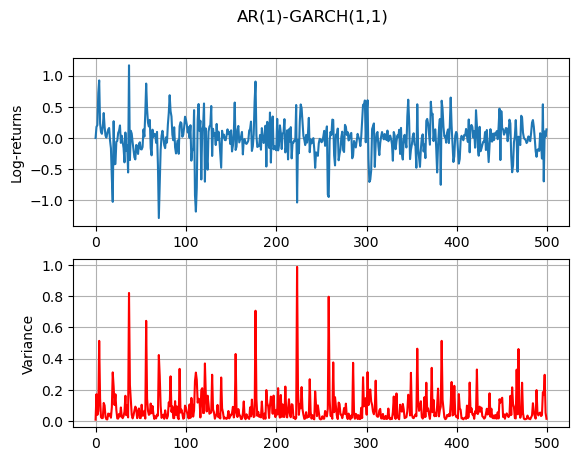

In [93]:
fig, axs = plt.subplots(2) 
axs[0].plot(trj)
axs[0].grid()
# axs[0].set_xlabel('Date')
axs[0].set_ylabel('Log-returns')
axs[1].plot(variance_trj, 'r')
axs[1].grid()
# axs[1].set_xlabel('Date')
axs[1].set_ylabel('Variance')
fig.suptitle('AR(1)-GARCH(1,1)')

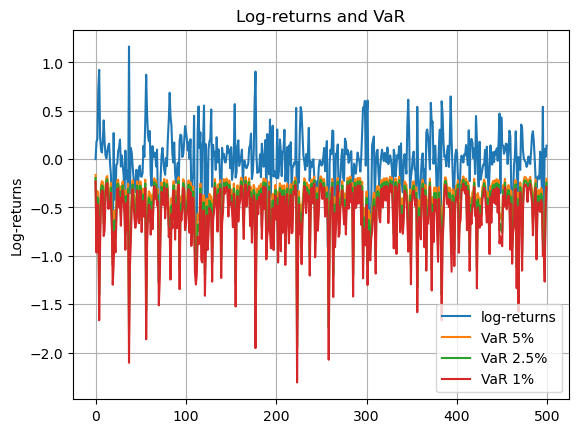

In [133]:
VaR005 = norm.ppf(0.05) * np.sqrt(variance_trj)
VaR025 = norm.ppf(0.025) * np.sqrt(variance_trj)
VaR001 = norm.ppf(0.01) * np.sqrt(variance_trj)

plt.plot(trj)
plt.plot(VaR005)
plt.plot(VaR025)
plt.plot(VaR001)
plt.grid()
plt.title('Log-returns and VaR')
#plt.xlabel('Date')
plt.ylabel('Log-returns')

plt.legend(['log-returns','VaR 5%','VaR 2.5%','VaR 1%'])
plt.show()

In [100]:
# Testing the fitting 

#params0 = np.array([0, 0, .1, 0.1, .1])
params0 = np.array([0, 0.0025, .2, .07, .1])

estimates = ar1_model.fit(params0, trj, 'L-BFGS-B')

print(estimates.parameters)

        parameters
mu        0.004031
beta1     0.009363
omega     0.239492
alpha1    0.061829
phi1      0.113203


In [101]:
print(estimates.jac)

[-0.00277376  0.00968504  0.00014496 -0.0018878   0.00059128]


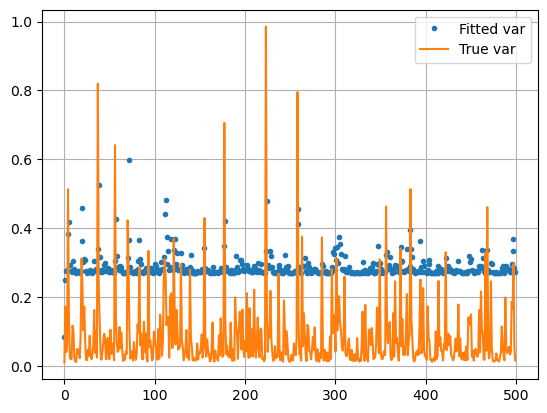

In [102]:
# let's extract the implied variance with the estimated parameters 

mu = float(estimates.parameters.loc['mu'])
omega = float(estimates.parameters.loc['omega'])
beta = np.array(estimates.parameters.loc['beta1'])
alpha = np.array(estimates.parameters.loc['alpha1'])
phi = np.array(estimates.parameters.loc['phi1'])

implied_variance, eps = ar1garch11_model.get_vol(trj, mu, beta, omega, alpha, phi)

plt.plot(implied_variance, '.')
plt.plot(variance_trj)
plt.grid()
plt.legend(['Fitted var', 'True var'])
plt.title('')
plt.show()


It's easy to see that the optimization process tends to produce parameters that generates a more stable variance process than the true one, and to meet the peaks in the vol it tends to set a higher value of the intercept of the vol process. This is something the happens quite often when working with time series models. The reason for this is due to the highly non linearity of the models used in time series analysis within the need to reproduce 500 dependent obesrvations of a latent variable (the variance). This happens even with the publicy available packages, so be carefull when working with these models, expecially with more complicated likelihood functions.

In [120]:
start_time = time()

start = 300 

mu_trj = np.empty((len(trj)-start))
omega_trj = np.empty((len(trj)-start))
beta_trj = np.empty((len(trj)-start))
alpha_trj = np.empty((len(trj)-start))
phi_trj = np.empty((len(trj)-start))

params0 = np.array([0, 0.0025, .2, .07, .1])

for i in range(start, len(trj)):
    
    # print(i)
    
    yt = trj[:i]
    
    estimates = ar1_model.fit(params0, yt, 'L-BFGS-B')
    
    mu_trj[i-start] = float(estimates.parameters.loc['mu'])
    omega_trj[i-start] = float(estimates.parameters.loc['omega'])
    beta_trj[i-start] = float(estimates.parameters.loc['beta1'])
    alpha_trj[i-start] = float(estimates.parameters.loc['alpha1'])
    phi_trj[i-start] = float(estimates.parameters.loc['phi1'])

end_time = time()

print('Enlapsed time : ' + str(end_time-start_time))
    

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
Enlapsed time : 3161.530268907547


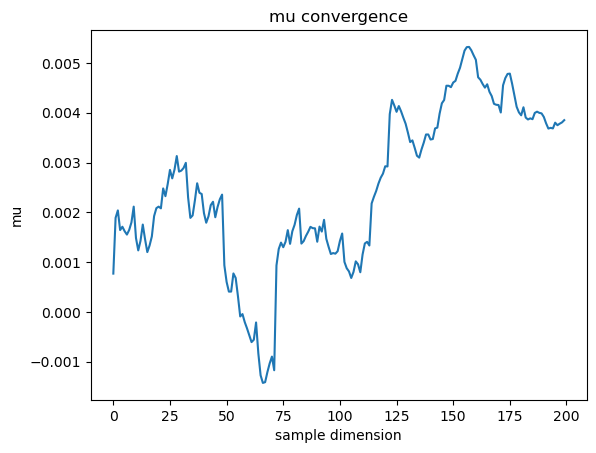

In [121]:
plt.plot(mu_trj)
plt.title('mu convergence')
plt.ylabel('mu')
plt.xlabel('sample dimension')
plt.show()

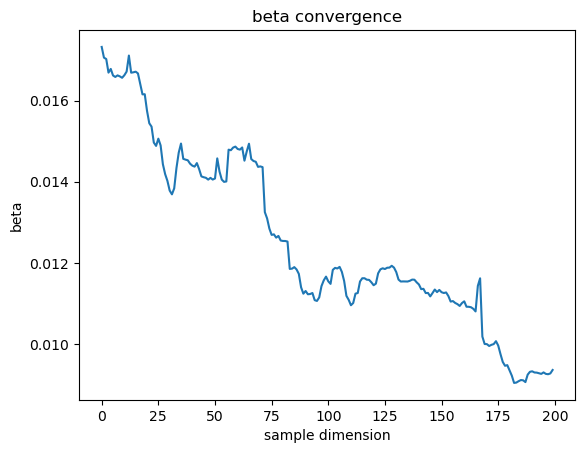

In [122]:
plt.plot(beta_trj)
plt.title('beta convergence')
plt.ylabel('beta')
plt.xlabel('sample dimension')
plt.show()

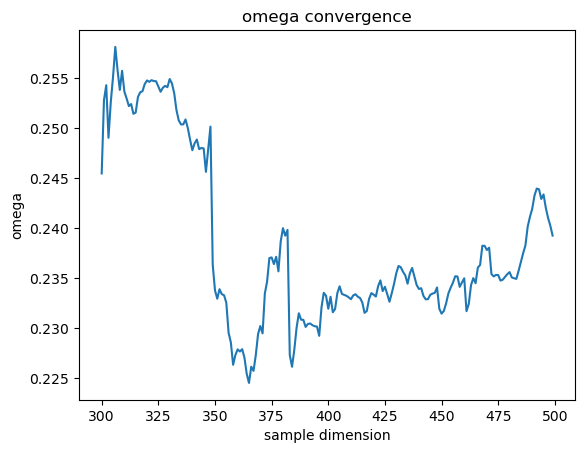

In [129]:
plt.plot(np.arange(0, len(omega_trj))+300, omega_trj)
plt.title('omega convergence')
plt.ylabel('omega')
plt.xlabel('sample dimension')
plt.show()

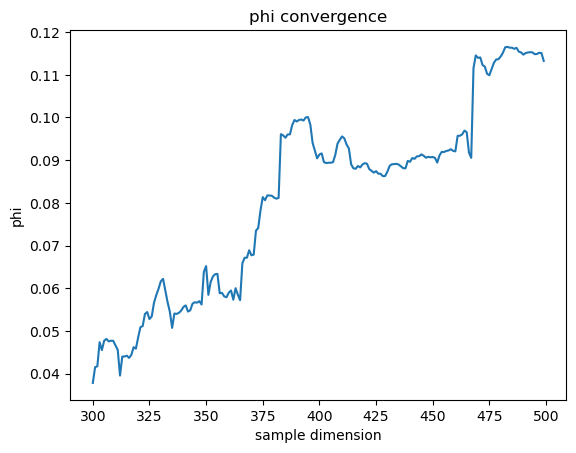

In [130]:
plt.plot(np.arange(0, len(omega_trj))+300, phi_trj)
plt.title('phi convergence')
plt.ylabel('phi')
plt.xlabel('sample dimension')
plt.show()

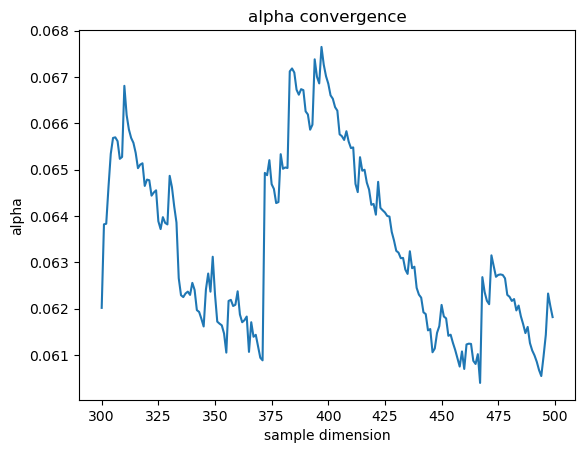

In [131]:
plt.plot(np.arange(0, len(omega_trj))+300, alpha_trj)
plt.title('alpha convergence')
plt.ylabel('alpha')
plt.xlabel('sample dimension')
plt.show()

So the pattern toward the convergence isn't smooth. 